# Word Embedding (Représentation vectorielle des mots)

**Word Embedding** est une représentation des mots qui permet à des mots ayant un sens similaire d’avoir une représentation semblable. Il s'agit d'une méthode d'apprentissage non supervisé sur un vaste corpus textuel, où le modèle apprend à prédire un mot à partir de son contexte ou inversement. Une fois entraîné, cette méthode produit des représentations vectorielles où des mots proches dans cet espace à haute dimension sont censés être sémantiquement similaires.

Contrairement à une simple assignation de vecteurs uniques par mot, les embeddings capturent des similarités **sémantiques** ou **syntaxiques** basées sur le corpus d'entraînement. Les vecteurs d'embedding contiennent souvent des centaines de dimensions et identifient des relations nuancées entre les mots.

![word_embed](./asset/word_embed.png)

---

## Couche d'Embedding (Embedding Layer)

Une **couche d'embedding** en apprentissage machine permet de créer des représentations vectorielles (embeddings) à partir de séquences d’entrée. Elle associe des mots ou des indices entiers à des vecteurs denses de nombres réels.

### Processus :
- En entrée : une séquence d'indices de mots (par exemple, des entiers correspondant à des mots dans un vocabulaire).
- En sortie : un tenseur où chaque séquence garde sa longueur originale, mais chaque mot/entier est représenté par un vecteur dense.

Ces vecteurs capturent les relations **sémantiques** entre les mots. La dimensionnalité de ces vecteurs est un hyperparamètre que l’on peut ajuster selon la tâche.

---

### Utilisation basique

La couche d'embedding agit uniquement comme une **table de correspondance**. Chaque index est associé à un vecteur dense qui peut être mis à jour lors de l'entraînement.

In [ ]:
!pip install -U -q torch transformers pandas numpy matplotlib

In [2]:
import torch
import torch.nn as nn

# Création d'un dictionnaire qui associe chaque mot à un index unique
word_to_ix = {"hello": 0, "world": 1}

# Initialisation de la couche d'embedding (représentation vectorielle pour les mots)
# - num_embeddings : taille du vocabulaire (le nombre de mots uniques, ici 2)
# - embedding_dim : dimensionnalité des vecteurs d'embedding (ici 5). Chaque mot sera représenté par un vecteur de 5 dimensions.
embeds = nn.Embedding(num_embeddings=2, embedding_dim=5)

# Transformation du mot "hello" (indexé par 0) en tenseur (tensor)
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)

# Récupération de l'embedding (vecteur) correspondant au mot "hello" via la couche d'embedding
hello_embed = embeds(lookup_tensor)

print(hello_embed)

tensor([[ 0.1308, -0.5292,  0.0655, -1.2621, -1.4788]],
       grad_fn=<EmbeddingBackward0>)


Paramètres d'entrainements

In [3]:
for param in embeds.parameters():
    print(param)

Parameter containing:
tensor([[ 0.1308, -0.5292,  0.0655, -1.2621, -1.4788],
        [-0.8911, -0.6452, -1.5637,  0.1437,  0.4515]], requires_grad=True)


Juste pour le fun on définie nos propres paramètres


In [4]:
embedding_lookup = torch.tensor([
    [1, 0, 0, 0, 1],
    [0, 1, 1, 1, 0],
    ], dtype=torch.float32)
embeds.weight = nn.Parameter(embedding_lookup)
for param in embeds.parameters():
    print(param)

Parameter containing:
tensor([[1., 0., 0., 0., 1.],
        [0., 1., 1., 1., 0.]], requires_grad=True)


Comme vous pouvez le constater, si je sélectionne l'index 0 ou 1, j'obtiens ma ligne embedding_lookup

In [5]:
print(embeds(torch.tensor([0])))
print(embeds(torch.tensor([1])))

tensor([[1., 0., 0., 0., 1.]], grad_fn=<EmbeddingBackward0>)
tensor([[0., 1., 1., 1., 0.]], grad_fn=<EmbeddingBackward0>)


## GPT embedding

Regardons le tout premier modèle GPT et voyons la taille de la couche d'embedding.

In [6]:
from transformers import GPT2Tokenizer, GPT2Model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

print("vocab size", tokenizer.vocab_size)

# expected Embedding(50257, 768)
# 50257 = vocabulary size
# 768 = number of features
print("Embedding size", model.wte)
print(inputs)

C:\Users\swanb\AppData\Local\pypoetry\Cache\virtualenvs\non-package-mode-14fOBzyQ-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\swanb\AppData\Local\pypoetry\Cache\virtualenvs\non-package-mode-14fOBzyQ-py3.12\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\swanb\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to

vocab size 50257
Embedding size Embedding(50257, 768)
{'input_ids': tensor([[15496,    11,   616,  3290,   318, 13779]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}



[Regardont le code de ce GPT](https://github.com/huggingface/transformers/blob/v4.25.1/src/transformers/models/gpt2/modeling_gpt2.py#L667)


## Entraîner la première couche d'embedding

Dans cette section, nous allons entraîner notre première couche d'embedding sur des avis de parcs Disney !
Pour commencer, nous entraînerons uniquement cette couche sur les lettres composant les mots.



In [7]:
import pandas as pd

# Load and take subset of the dataset
df = pd.read_csv("data/disney_review/train.csv")[:5000]
df.head()

,Unnamed: 0,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,16833,333121929,5,2015-12,United States,Truly the most magical place on the West Coast...,Disneyland_California
1,28602,71690002,5,missing,Canada,"I cry every time we have to leave this place, ...",Disneyland_California
2,32094,481683772,5,2017-4,United Kingdom,"Staff everywhere were just friendly, the custo...",Disneyland_Paris
3,16576,339637317,5,2016-1,United States,"It's Disneyland, what more is there to say? W...",Disneyland_California
4,13962,438710000,5,2016-10,United Kingdom,We visited this park at Halloween and enjoyed ...,Disneyland_California


In [8]:
# Count each deffrent values of rating
df['Rating'].value_counts()

Rating
5    2662
4    1274
3     610
2     260
1     194
Name: count, dtype: int64

In [9]:
# Get reviews
reviews = df["Review_Text"].values.tolist()

Maintenant, nous allons créer une séquence de lettres basée sur des phrases.
Par exemple :

```
aba decides a
```

produira:

```
[
  ('a', 'b'),
  ('b', 'a'),
  ('a', ' '),
  (' ', 'd'),
  ('d', 'e'),
  ('e', 'c'),
  ('c', 'i'),
  ('i', 'd'),
  ('d', 'e'),
  ('e', 's'),
  ('s', ' '),
  (' ', 'a'),
]
```

In [10]:
import itertools as it
import re


def sliding_window(txt):
    # Génère des paires de caractères (bigrammes) à partir du texte donné
    # Exemple : 'chat' -> ('c', 'h'), ('h', 'a'), ('a', 't')
    for i in range(len(txt) - 1):
        yield txt[i], txt[i + 1]


window = []

for title in reviews:
    # Nettoie chaque titre pour ne conserver que les lettres (a-z) et les chiffres (0-9)
    title = re.sub('[^a-zA-Z0-9]+', '', title.lower())

    # Applique la fonction sliding_window au titre nettoyé et l'ajoute à la liste `window`
    window.append(sliding_window(title))

window = list(it.chain(*window))

# Affiche le nombre total de paires (bigrammes) générées
print(len(window))

# Affiche les 5 premières paires générées en guise d'exemple
window[:5]

2699406


[('t', 'r'), ('r', 'u'), ('u', 'l'), ('l', 'y'), ('y', 't')]

Maintenant, effectuons un encodage one-hot de manière à ce qu'une lettre corresponde à un identifiant (comme un identifiant dans une table SQL).

```
{' ': 2,
 'a': 0,
 'b': 1,
 'c': 5,
 'd': 3,
 'e': 4,
 'g': 8,
 'i': 6,
 'l': 16,
 'm': 12,
 'n': 9,
 'o': 11,
 'r': 15,
 's': 7,
 't': 10,
 'u': 13,
 'y': 14}
```

In [13]:
import numpy as np

# Mapping lettre avec un ID
mapping = {c: i for i, c in enumerate(pd.DataFrame(window)[0].unique())}
# Id en entrée du modèle
integers_in = np.array([mapping[w[0]] for w in window])
# Id en sortie du modèle
integers_out = np.array([mapping[w[1]] for w in window])

print("Shape of input", integers_in.shape)
print("Input example", integers_in[0], integers_out[0])
print("Show generate mapping\n", mapping)

Shape of input (2699406,)
Input example 0 1
Show generate mapping
 {'t': 0, 'r': 1, 'u': 2, 'l': 3, 'y': 4, 'h': 5, 'e': 6, 'm': 7, 'o': 8, 's': 9, 'a': 10, 'g': 11, 'i': 12, 'c': 13, 'p': 14, 'n': 15, 'w': 16, 'd': 17, 'b': 18, 'v': 19, 'f': 20, 'k': 21, 'j': 22, '1': 23, '9': 24, '5': 25, '6': 26, '0': 27, 'q': 28, '7': 29, '2': 30, 'x': 31, 'z': 32, '3': 33, '4': 34, '8': 35}


### La classe Dataset

La classe `Dataset` résume les fonctionnalités de base d'un jeu de données de manière naturelle.
Pour définir un jeu de données dans PyTorch, il suffit d'implémenter deux fonctions principales : `__getitem__` et `__len__`.

1. **`__getitem__`** : Cette fonction doit retourner le i-ème échantillon du jeu de données.
2. **`__len__`** : Cette fonction retourne la taille totale du jeu de données.

Ces deux fonctions garantissent une structure cohérente et standardisée pour interagir avec vos données.

In [14]:
from typing import List, Tuple
import torch.utils.data as data


class NextLetterDataset(data.Dataset):
    def __init__(self, integers_in: List[int], integers_out: List[int]):
        self.integers_in = integers_in  # Stocke les données d'entrée
        self.integers_out = integers_out  # Stocke les étiquettes de sortie

    def __len__(self):
        return len(self.integers_in)

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        """
        Retourne le i-ème échantillon et son étiquette à partir du dataset.
        Les données et étiquettes sont converties en tenseurs PyTorch avant d'être renvoyées.

        Args:
        - idx (int): L'index de l'échantillon à récupérer.

        Returns:
        - Tuple[torch.tensor, torch.tensor]: Une paire contenant :
            - Le tenseur représentant la lettre en entrée
            - Le tenseur représentant la lettre en sortie
        """
        data_point = self.integers_in[idx]
        data_label = self.integers_out[idx]
        return torch.tensor(data_point), torch.tensor(data_label, dtype=torch.int64)

## Construire le premier modèle d'embedding
Nous allons construire un réseau simple pour prédire la lettre suivante.

![Prédiction de la lettre suivante](./asset/next_letter_prediction.png)

In [15]:



class NextLetterPrediction(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(NextLetterPrediction, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.fc = torch.nn.Linear(embedding_size, vocab_size)

    def forward(self, x):
        x = F.relu(self.embedding(x))
        x = self.fc(x)
        return x

### Visualisation des lettres avant l'entraînement
Visualisons les embeddings des lettres avant l'entraînement du modèle.

In [18]:
model = NextLetterPrediction(vocab_size=len(mapping),
                             # pour l'axe X et Y
                             embedding_size=2)

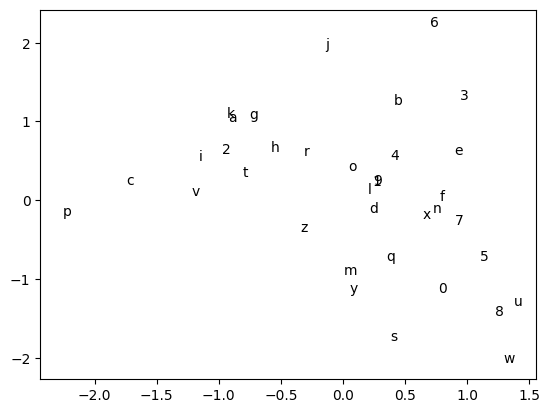

In [19]:
import matplotlib.pylab as plt

idx_to_calc = list(mapping.values())
idx_to_calc = np.array([idx_to_calc]).T

translator = {v: k for k, v in mapping.items()}
preds = model.embedding(torch.tensor(idx_to_calc)).detach().numpy()
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
    plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])

### Train loop


In [20]:
# Initialisation du dataset dans le DataLoader
# On crée une instance de la classe NextLetterDataset.
# Les arguments "integers_in" et "integers_out" représentent respectivement les entrées et les sorties du modèle.
# Le DataLoader est utilisé pour faciliter le traitement du dataset, notamment en divisant les données en batchs
# de taille spécifiée (ici, batch_size=128) et en mélangeant les données (shuffle=True) à chaque époque d'entraînement.
dataset = NextLetterDataset(integers_in, integers_out)
trainloader = data.DataLoader(dataset, batch_size=128, shuffle=True)

# Définition de la fonction de perte (loss function) et de l'optimiseur
# criterion : On utilise la fonction de perte CrossEntropyLoss, adaptée pour les tâches de classification
# multi-classes. Elle compare les prédictions du modèle avec les vraies étiquettes, calculant ainsi une mesure
# de la distance entre les deux.
criterion = nn.CrossEntropyLoss()

# optimizer : AdamW est un algorithme d'optimisation basé sur Adam, accompagné d'une régularisation de poids
# (Weight Decay). Cela aide à éviter le surapprentissage tout en ajustant les paramètres du modèle pour minimiser
# la fonction de perte. Le taux d'apprentissage (lr) est fixé ici à 0.01.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [21]:
# Définir le nombre d'époques pour l'entraînement
epoches = 1

# Vérifie si un GPU CUDA est disponible ; sinon, utilise le CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Charger le modèle sur le dispositif choisi (GPU ou CPU) en mode entraînement.
model = model.to(device)
model.train()

# Boucle principale d'entraînement sur plusieurs époques.
# Une époque représente une passe complète à travers toutes les données.
for epoch in range(epoches):
    running_loss = 0.0  # Initialisation de la perte agrégée pour cette époque

    # Boucle interne pour itérer sur le *DataLoader* (trainloader).
    # *trainloader* fournit des lots (batchs) contenant des données d’entrée et leurs étiquettes.
    for i, batch in enumerate(trainloader, 0):
        inputs, labels = batch

        # Transférer ces données vers le GPU (ou rester sur le CPU selon l’appareil défini).
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Réinitialise les gradients précédents. Cela est essentiel car les gradients calculés
        # pour chaque mini-lot s'accumulent par défaut dans PyTorch.
        optimizer.zero_grad()

        # Phase avant : génère des prédictions du modèle en passant les entrées dans le réseau.
        outputs = model(inputs)

        # Calcul de la perte en comparant les prédictions (outputs) avec les étiquettes attendues (labels).
        loss = criterion(outputs, labels)

        # Phase arrière : rétropropagation pour calculer les gradients des paramètres.
        loss.backward()

        # Mise à jour des poids du modèle en utilisant les gradients calculés.
        optimizer.step()

        # Mise à jour de la perte cumulée pour les lots traités jusqu’à présent.
        running_loss += loss.item()

        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0  # Réinitialise la perte pour le prochain groupe de 2000 lots

cuda
[1,  2000] loss: 2.804
[1,  4000] loss: 2.730
[1,  6000] loss: 2.726
[1,  8000] loss: 2.732
[1, 10000] loss: 2.732
[1, 12000] loss: 2.730
[1, 14000] loss: 2.731
[1, 16000] loss: 2.728
[1, 18000] loss: 2.728
[1, 20000] loss: 2.732


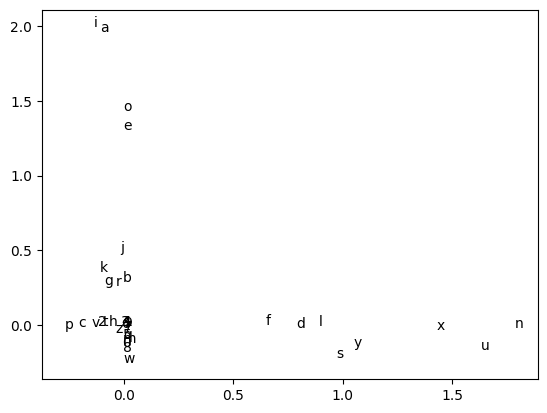

In [22]:
idx_to_calc = list(mapping.values())
idx_to_calc = np.array([idx_to_calc]).T

translator = {v: k for k, v in mapping.items()}
preds = model.embedding(torch.tensor(idx_to_calc).to(device)).cpu().detach().numpy()
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
    plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])

In [45]:
import torch
from transformers import BertModel
from transformers import AutoTokenizer
import torch.nn.functional as F
# To train a model on `num_labels` classes, you can pass `num_labels=num_labels` to `.from_pretrained(...)`
num_labels = 3
model = BertModel.from_pretrained("google-bert/bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

In [56]:
inputs = tokenizer("queen", return_tensors="pt")
output1 = model(**inputs, output_hidden_states=True)

inputs = tokenizer("yolo", return_tensors="pt")
output2 = model(**inputs, output_hidden_states=True)
# Calculate cosine similarity between the two pooler outputs
cosine_sim = F.cosine_similarity(output1.pooler_output, output2.pooler_output, dim=1)

print(f"Cosine similarity: {cosine_sim.item():.4f}")

Cosine similarity: 0.9436
